In [19]:
pip install opencv-contrib-python Pillow matplotlib torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [21]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "./Images/monet_jpg/"
TEST_IMAGES_PATH = "./Images/photo_jpg/"

lr = 0.0001
beta1 = 0.5
beta2 = 0.996
n_epoches = 90
decay_epoch = 40
display_epoch = 25

In [22]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [23]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms
        
        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]
        
    def __len__(self):
        return len(self.monet_images_X)
    
    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])

        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [24]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [25]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)
    
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

In [27]:
G_XY = GeneratorResNet(3, num_residual_blocks=9)
D_Y = Discriminator(3)

G_YX = GeneratorResNet(3, num_residual_blocks=9)
D_X = Discriminator(3)

In [28]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

# Transfer models to CUDA if available
models = [G_XY, D_Y, G_YX, D_X]
for model in models:
    if cuda_available:
        model.cuda()

gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

CUDA Available: False


In [29]:
optimizer_G = torch.optim.Adam(itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

In [30]:
def learning_rate_decay(epoch, decay_start_epoch, total_epochs):
    if epoch < decay_start_epoch:
        return 1
    else:
        return 1 - (epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))

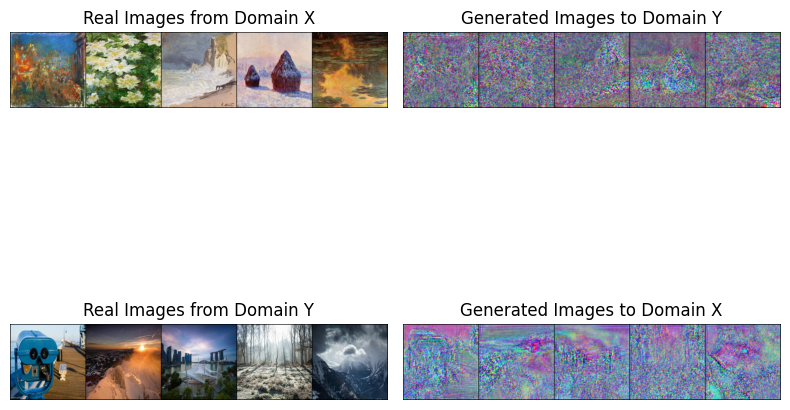

In [31]:
def sample_images(real_X, real_Y):    
    G_XY.eval()
    G_YX.eval()

    real_X = real_X.type(Tensor)
    fake_Y = G_XY(real_X).detach()

    real_Y = real_Y.type(Tensor)
    fake_X = G_YX(real_Y).detach()

    ncols = real_X.size(0)
    real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
    fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
    real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
    fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  

    axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu())
    axs[0, 0].set_title("Real Images from Domain X")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Generated Images to Domain Y")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu())
    axs[1, 0].set_title("Real Images from Domain Y")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu())
    axs[1, 1].set_title("Generated Images to Domain X")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)